# 糖尿病 BRFSS 2021 資料集

糖尿病是一種慢性健康狀況，會影響您的身體將食物轉化為能量的方式。糖尿病主要分為三種：1 型、2 型和妊娠期糖尿病。
Type 1 diabetes is an autoimmune disease that causes your body to attack the cells in your pancreas that produce insulin. Insulin is a hormone that helps your body use glucose for energy.
1 型糖尿病是一種自體免疫疾病，會導致您的身體攻擊胰臟中產生胰島素的細胞。胰島素是一種幫助您的身體利用葡萄糖獲取能量的荷爾蒙。

Type 2 diabetes is the most common type of diabetes. It occurs when your body doesn't respond normally to insulin, or when your body doesn't produce enough insulin.
2 型糖尿病是最常見的糖尿病類型。當您的身體對胰島素沒有正常反應，或者您的身體無法產生足夠的胰島素時，就會發生這種情況。

Gestational diabetes is a type of diabetes that develops during pregnancy. It usually goes away after the baby is born.
妊娠糖尿病是一種在懷孕期間發生的糖尿病。通常在嬰兒出生後就會消失。

In [40]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
import os

from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler


import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

import warnings
warnings.filterwarnings(action='ignore')

df = pd.read_csv('../input/diabetes_binary_5050split_health_indicators_BRFSS2021.csv')
df.head()
X = df.drop(columns=['Diabetes_binary'])
y = df['Diabetes_binary']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [ ]:
# df.info()
df.columns  

In [ ]:
# 繪製Diabetes_binary的分布圖
# plt.figure(figsize=(10, 6))
ax = sns.countplot(x='Diabetes_binary', data=df,palette='hls')
plt.xlabel('Diabetes_binary')
plt.ylabel('Count')
plt.title('Diabetes_012 Distribution')
# 在每個bar上顯示數值
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
                textcoords='offset points')
plt.show()

In [ ]:
# 繪製相關係數圖
plt.figure(figsize=(40, 40))
# 字體大小
sns.set(font_scale=2)
sns.heatmap(df.corr().round(2), annot=True, cmap='BuGn')
plt.title('Correlation Heatmap')
plt.show()


## 開始建模

In [6]:
# 開始建模並且微調參數
from pycaret.classification import *
clf1 = setup(
    data = df,
    target = 'Diabetes_binary',
    preprocess = False,
    train_size = 0.7,
    fold_strategy = 'stratifiedkfold',
    fold = 10,
    
)

,Description,Value
0,Session id,5764
1,Target,Diabetes_binary
2,Target type,Binary
3,Original data shape,"(67136, 22)"
4,Transformed data shape,"(67136, 22)"
5,Transformed train set shape,"(46995, 22)"
6,Transformed test set shape,"(20141, 22)"
7,Numeric features,21


In [7]:
top_5 = compare_models(
        sort = 'AUC',
        n_select=5,
        exclude = ['lightgbm','dummy','svm','ridge','knn','dt','nb','qda']
        )

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.7450,0.8212,0.7826,0.7279,0.7543,0.4900,0.4915,0.4190
catboost,CatBoost Classifier,0.7444,0.8198,0.7864,0.7255,0.7547,0.4887,0.4905,4.1190
ada,Ada Boost Classifier,0.7439,0.8175,0.7640,0.7346,0.7490,0.4879,0.4883,0.1440
lr,Logistic Regression,0.7414,0.8159,0.7599,0.7328,0.7461,0.4828,0.4832,0.5990
lda,Linear Discriminant Analysis,0.7403,0.8153,0.7644,0.7292,0.7464,0.4805,0.4811,0.0440
xgboost,Extreme Gradient Boosting,0.7397,0.8134,0.7761,0.7235,0.7488,0.4794,0.4807,0.0860
rf,Random Forest Classifier,0.7315,0.8006,0.7661,0.7165,0.7404,0.4629,0.4641,0.5830
et,Extra Trees Classifier,0.7200,0.7846,0.7517,0.7070,0.7286,0.4401,0.4410,0.4610


In [28]:
gbc = create_model('gbc')
cat = create_model('catboost')
ada = create_model('ada')
lr  = create_model('lr')
lda  = create_model('lda')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7536,0.8263,0.7872,0.7376,0.7616,0.5072,0.5084
1,0.7464,0.8264,0.7800,0.7309,0.7546,0.4928,0.4939
2,0.7419,0.8171,0.7817,0.7241,0.7518,0.4838,0.4854
3,0.7528,0.8266,0.7864,0.7368,0.7608,0.5055,0.5067
4,0.7500,0.8267,0.7826,0.7347,0.7579,0.5000,0.5011
5,0.7359,0.8085,0.7820,0.7159,0.7475,0.4718,0.4738
6,0.7404,0.8253,0.7739,0.7252,0.7488,0.4807,0.4818
7,0.7429,0.8166,0.7833,0.7247,0.7529,0.4859,0.4875
8,0.7446,0.8218,0.7762,0.7302,0.7525,0.4892,0.4902


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7526,0.8256,0.7928,0.7338,0.7621,0.5051,0.5067
1,0.7426,0.8242,0.7791,0.7260,0.7516,0.4851,0.4864
2,0.7434,0.8179,0.7855,0.7245,0.7538,0.4868,0.4885
3,0.7509,0.8246,0.7855,0.7346,0.7592,0.5017,0.5029
4,0.7500,0.8268,0.7877,0.7325,0.7591,0.5000,0.5014
5,0.7323,0.8078,0.7820,0.7112,0.7449,0.4646,0.4669
6,0.7459,0.8225,0.7850,0.7280,0.7554,0.4918,0.4933
7,0.7425,0.8163,0.7901,0.7213,0.7542,0.4850,0.4872
8,0.7425,0.8188,0.7813,0.7251,0.7522,0.4850,0.4865


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7521,0.8229,0.7651,0.7457,0.7553,0.5043,0.5044
1,0.7438,0.8219,0.7591,0.7366,0.7477,0.4877,0.4879
2,0.7411,0.8148,0.7660,0.7296,0.7474,0.4821,0.4827
3,0.7526,0.8234,0.7698,0.7441,0.7567,0.5051,0.5054
4,0.7474,0.8216,0.7643,0.7394,0.7516,0.4949,0.4952
5,0.7351,0.8054,0.7616,0.7231,0.7419,0.4701,0.4708
6,0.7380,0.8204,0.7578,0.7289,0.7431,0.4761,0.4764
7,0.7402,0.8140,0.7612,0.7304,0.7455,0.4803,0.4807
8,0.7451,0.8185,0.7574,0.7392,0.7482,0.4901,0.4903


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7472,0.8213,0.7672,0.7377,0.7522,0.4945,0.4949
1,0.7415,0.8194,0.7570,0.7342,0.7454,0.4830,0.4832
2,0.7357,0.8116,0.7536,0.7276,0.7404,0.4715,0.4718
3,0.7496,0.8220,0.7668,0.7413,0.7538,0.4991,0.4994
4,0.7470,0.8200,0.7664,0.7378,0.7518,0.4940,0.4944
5,0.7368,0.8039,0.7569,0.7275,0.7419,0.4735,0.4739
6,0.7376,0.8161,0.7535,0.7302,0.7417,0.4752,0.4755
7,0.7378,0.8131,0.7573,0.7288,0.7428,0.4756,0.4760
8,0.7429,0.8193,0.7515,0.7389,0.7451,0.4858,0.4859


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7470,0.8204,0.7685,0.7368,0.7523,0.4940,0.4945
1,0.7377,0.8182,0.7621,0.7266,0.7439,0.4753,0.4759
2,0.7370,0.8116,0.7604,0.7264,0.7430,0.4740,0.4746
3,0.7472,0.8209,0.7711,0.7360,0.7531,0.4945,0.4950
4,0.7453,0.8197,0.7702,0.7337,0.7515,0.4906,0.4912
5,0.7365,0.8033,0.7637,0.7243,0.7435,0.4731,0.4738
6,0.7361,0.8164,0.7548,0.7275,0.7409,0.4722,0.4726
7,0.7374,0.8128,0.7646,0.7251,0.7443,0.4748,0.4755
8,0.7414,0.8188,0.7549,0.7352,0.7449,0.4829,0.4830


## Interpret Model

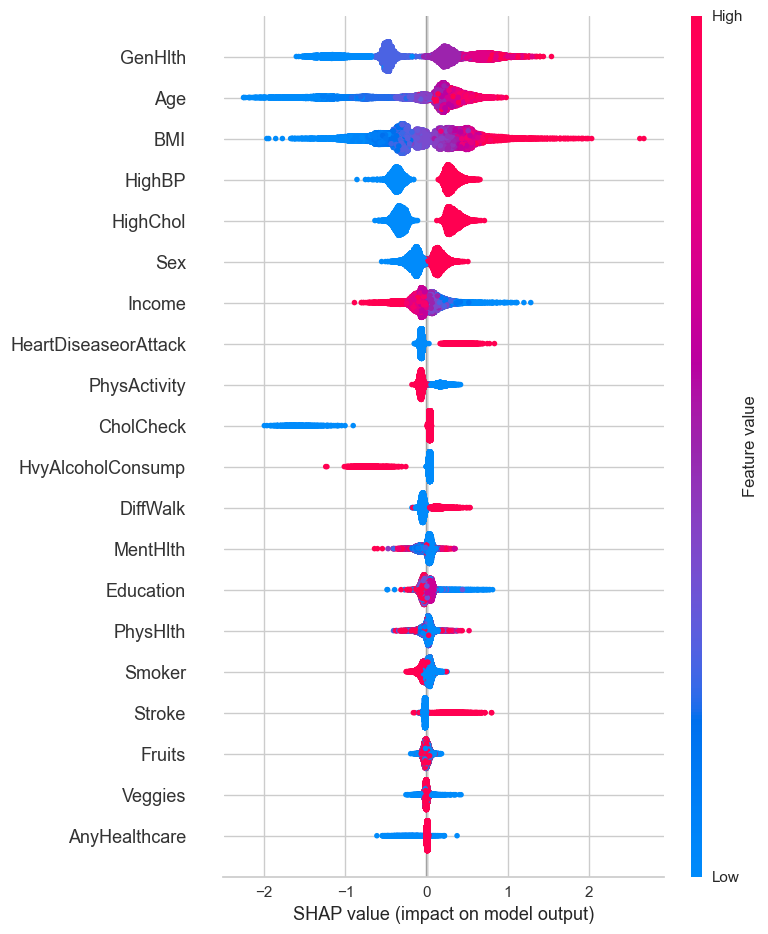

In [9]:
interpret_model(cat)

## Tuning_model

In [29]:
tuned_gbc = tune_model(gbc, optimize = 'AUC',search_library='tune-sklearn',search_algorithm = 'bayesian')
tuned_cat = tune_model(cat, optimize = 'AUC',search_library='optuna',search_algorithm = 'tpe')
tuned_ada = tune_model(ada, optimize = 'AUC',search_library='optuna',search_algorithm = 'tpe')
tuned_lr  = tune_model(lr, optimize = 'AUC',search_library='optuna',search_algorithm = 'tpe')
tuned_lda = tune_model(lda, optimize = 'AUC',search_library='optuna',search_algorithm = 'tpe')

2023-12-05 15:52:03,377	INFO tune.py:1047 -- Total run time: 98.55 seconds (98.53 seconds for the tuning loop).


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7549,0.8275,0.7936,0.7366,0.7640,0.5098,0.5113
1,0.7479,0.8274,0.7838,0.7312,0.7566,0.4957,0.4970
2,0.7426,0.8192,0.7868,0.7228,0.7535,0.4851,0.4870
3,0.7519,0.8282,0.7894,0.7344,0.7609,0.5038,0.5052
4,0.7498,0.8285,0.7881,0.7320,0.7590,0.4996,0.5010
5,0.7370,0.8101,0.7863,0.7156,0.7493,0.4739,0.4763
6,0.7453,0.8268,0.7846,0.7273,0.7549,0.4905,0.4921
7,0.7419,0.8190,0.7901,0.7205,0.7537,0.4837,0.4860
8,0.7444,0.8229,0.7791,0.7286,0.7530,0.4888,0.4900


[I 2023-12-05 15:52:22,353] Searching the best hyperparameters using 46995 samples...
[I 2023-12-05 15:54:19,756] Finished hyperparameter search!


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7511,0.8230,0.7694,0.7422,0.7555,0.5021,0.5025
1,0.7438,0.8223,0.7613,0.7356,0.7482,0.4877,0.4880
2,0.7421,0.8147,0.7694,0.7296,0.7490,0.4843,0.4850
3,0.7543,0.8245,0.7745,0.7444,0.7591,0.5085,0.5089
4,0.7496,0.8230,0.7672,0.7411,0.7539,0.4991,0.4995
5,0.7327,0.8067,0.7595,0.7208,0.7396,0.4654,0.4661
6,0.7380,0.8209,0.7578,0.7289,0.7431,0.4761,0.4764
7,0.7376,0.8146,0.7586,0.7279,0.7430,0.4752,0.4756
8,0.7433,0.8191,0.7540,0.7383,0.7461,0.4867,0.4868


[I 2023-12-05 15:55:22,509] Searching the best hyperparameters using 46995 samples...
[I 2023-12-05 15:56:18,900] Finished hyperparameter search!


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7479,0.8213,0.7677,0.7384,0.7528,0.4957,0.4961
1,0.7415,0.8195,0.7570,0.7342,0.7454,0.4830,0.4832
2,0.7364,0.8116,0.7540,0.7283,0.7410,0.4728,0.4731
3,0.7496,0.8220,0.7668,0.7413,0.7538,0.4991,0.4994
4,0.7466,0.8200,0.7660,0.7374,0.7514,0.4932,0.4936
5,0.7372,0.8039,0.7569,0.7281,0.7422,0.4744,0.4747
6,0.7374,0.8161,0.7531,0.7301,0.7414,0.4748,0.4750
7,0.7380,0.8131,0.7578,0.7289,0.7431,0.4761,0.4764
8,0.7429,0.8193,0.7515,0.7389,0.7451,0.4858,0.4859


[I 2023-12-05 15:56:27,105] Searching the best hyperparameters using 46995 samples...
[I 2023-12-05 15:56:59,880] Finished hyperparameter search!


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7487,0.8204,0.7715,0.7379,0.7543,0.4974,0.4980
1,0.7377,0.8179,0.7609,0.7271,0.7436,0.4753,0.4758
2,0.7374,0.8115,0.7604,0.7270,0.7433,0.4749,0.4754
3,0.7470,0.8208,0.7706,0.7359,0.7529,0.4940,0.4946
4,0.7464,0.8197,0.7711,0.7348,0.7525,0.4928,0.4934
5,0.7380,0.8033,0.7642,0.7261,0.7447,0.4761,0.4767
6,0.7365,0.8162,0.7544,0.7283,0.7411,0.4731,0.4734
7,0.7370,0.8126,0.7633,0.7250,0.7437,0.4739,0.4746
8,0.7404,0.8186,0.7540,0.7341,0.7439,0.4807,0.4809


[I 2023-12-05 15:57:08,790] Searching the best hyperparameters using 46995 samples...
[I 2023-12-05 15:57:10,156] Finished hyperparameter search!


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [30]:
tuned_gbc = create_model(tuned_gbc)
tuned_cat = create_model(tuned_cat)
tuned_ada = create_model(tuned_ada)
tuned_lr  = create_model(tuned_lr)
tuned_lda = create_model(tuned_lda)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7572,0.8276,0.7962,0.7386,0.7663,0.5145,0.5160
1,0.7504,0.8265,0.7877,0.7331,0.7594,0.5009,0.5022
2,0.7404,0.8182,0.7813,0.7223,0.7506,0.4809,0.4825
3,0.7523,0.8277,0.7851,0.7368,0.7602,0.5047,0.5058
4,0.7481,0.8267,0.7826,0.7321,0.7565,0.4962,0.4974
5,0.7406,0.8102,0.7910,0.7185,0.7530,0.4812,0.4836
6,0.7421,0.8259,0.7727,0.7280,0.7497,0.4842,0.4851
7,0.7438,0.8171,0.7867,0.7244,0.7543,0.4876,0.4894
8,0.7465,0.8222,0.7834,0.7297,0.7556,0.4931,0.4944


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7549,0.8275,0.7936,0.7366,0.7640,0.5098,0.5113
1,0.7479,0.8274,0.7838,0.7312,0.7566,0.4957,0.4970
2,0.7426,0.8192,0.7868,0.7228,0.7535,0.4851,0.4870
3,0.7519,0.8282,0.7894,0.7344,0.7609,0.5038,0.5052
4,0.7498,0.8285,0.7881,0.7320,0.7590,0.4996,0.5010
5,0.7370,0.8101,0.7863,0.7156,0.7493,0.4739,0.4763
6,0.7453,0.8268,0.7846,0.7273,0.7549,0.4905,0.4921
7,0.7419,0.8190,0.7901,0.7205,0.7537,0.4837,0.4860
8,0.7444,0.8229,0.7791,0.7286,0.7530,0.4888,0.4900


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7511,0.8230,0.7694,0.7422,0.7555,0.5021,0.5025
1,0.7438,0.8223,0.7613,0.7356,0.7482,0.4877,0.4880
2,0.7421,0.8147,0.7694,0.7296,0.7490,0.4843,0.4850
3,0.7543,0.8245,0.7745,0.7444,0.7591,0.5085,0.5089
4,0.7496,0.8230,0.7672,0.7411,0.7539,0.4991,0.4995
5,0.7327,0.8067,0.7595,0.7208,0.7396,0.4654,0.4661
6,0.7380,0.8209,0.7578,0.7289,0.7431,0.4761,0.4764
7,0.7376,0.8146,0.7586,0.7279,0.7430,0.4752,0.4756
8,0.7433,0.8191,0.7540,0.7383,0.7461,0.4867,0.4868


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7472,0.8213,0.7672,0.7377,0.7522,0.4945,0.4949
1,0.7415,0.8194,0.7570,0.7342,0.7454,0.4830,0.4832
2,0.7357,0.8116,0.7536,0.7276,0.7404,0.4715,0.4718
3,0.7496,0.8220,0.7668,0.7413,0.7538,0.4991,0.4994
4,0.7470,0.8200,0.7664,0.7378,0.7518,0.4940,0.4944
5,0.7368,0.8039,0.7569,0.7275,0.7419,0.4735,0.4739
6,0.7376,0.8161,0.7535,0.7302,0.7417,0.4752,0.4755
7,0.7378,0.8131,0.7573,0.7288,0.7428,0.4756,0.4760
8,0.7429,0.8193,0.7515,0.7389,0.7451,0.4858,0.4859


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7470,0.8204,0.7685,0.7368,0.7523,0.4940,0.4945
1,0.7377,0.8182,0.7621,0.7266,0.7439,0.4753,0.4759
2,0.7370,0.8116,0.7604,0.7264,0.7430,0.4740,0.4746
3,0.7472,0.8209,0.7711,0.7360,0.7531,0.4945,0.4950
4,0.7453,0.8197,0.7702,0.7337,0.7515,0.4906,0.4912
5,0.7365,0.8033,0.7637,0.7243,0.7435,0.4731,0.4738
6,0.7361,0.8164,0.7548,0.7275,0.7409,0.4722,0.4726
7,0.7374,0.8128,0.7646,0.7251,0.7443,0.4748,0.4755
8,0.7414,0.8188,0.7549,0.7352,0.7449,0.4829,0.4830


## Stacking

In [36]:
top_5_tuned = [tuned_cat,tuned_gbc,tuned_ada,tuned_lr,tuned_lda]
stack_model = stack_models(estimator_list = top_5_tuned, meta_model = top_5_tuned[0],optimize = 'AUC')

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,16:03:18
Status,. . . . . . . . . . . . . . . . . .,Compiling Estimators
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7549,0.8287,0.7911,0.7377,0.7634,0.5098,0.5111
1,0.7504,0.8265,0.7817,0.7357,0.7580,0.5009,0.5018
2,0.7402,0.8188,0.7847,0.7206,0.7513,0.4804,0.4823
3,0.7549,0.8273,0.7996,0.7340,0.7654,0.5098,0.5118
4,0.7477,0.8275,0.7902,0.7282,0.7580,0.4953,0.4971
5,0.7389,0.8100,0.7825,0.7197,0.7497,0.4778,0.4796
6,0.7425,0.8255,0.7684,0.7305,0.7490,0.4850,0.4857
7,0.7429,0.8186,0.7923,0.7210,0.7550,0.4859,0.4882
8,0.7433,0.8224,0.7787,0.7273,0.7522,0.4867,0.4879


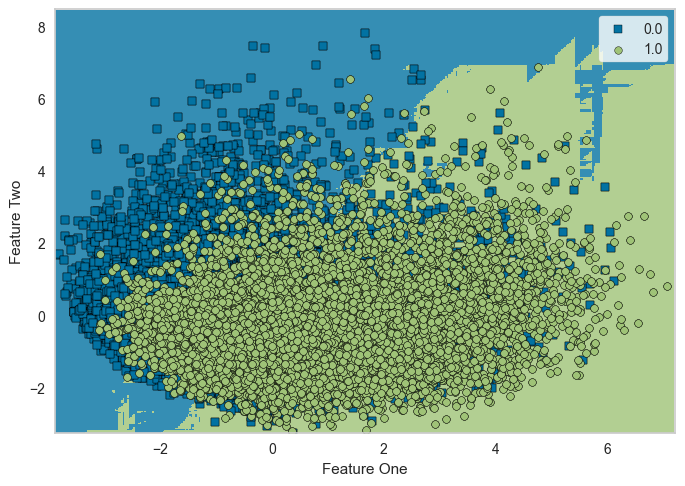

In [38]:
plt.figure(figsize=(8, 8))
plot_model(stack_model, plot='boundary')

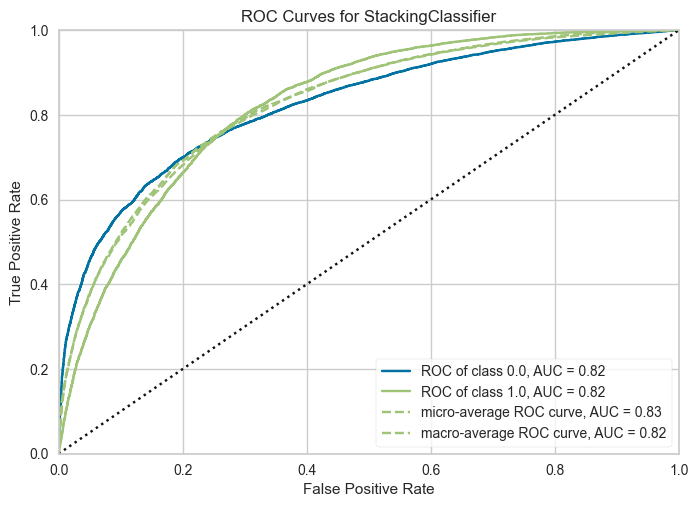

In [39]:
plt.figure(figsize=(8, 8))
plot_model(stack_model, plot = 'auc')

In [42]:
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)   
     
    roc_auc = roc_auc_score(y_test, pred_proba)

    # ROC-AUC print 
    print('accuracy: {0:.4f}, precision: {1:.4f}, recall: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))
    return confusion

In [43]:
#prediction
pred = stack_model.predict(X_test)
pred_proba = stack_model.predict_proba(X_test)[:,1]
#Accuracy
confusion_stack = get_clf_eval(y_test,pred,pred_proba)

accuracy: 0.7541, precision: 0.7415, recall: 0.7868,    F1: 0.7635, AUC:0.8299


Text(0.5, 1.0, 'Confusion Matrix (Stacking)')

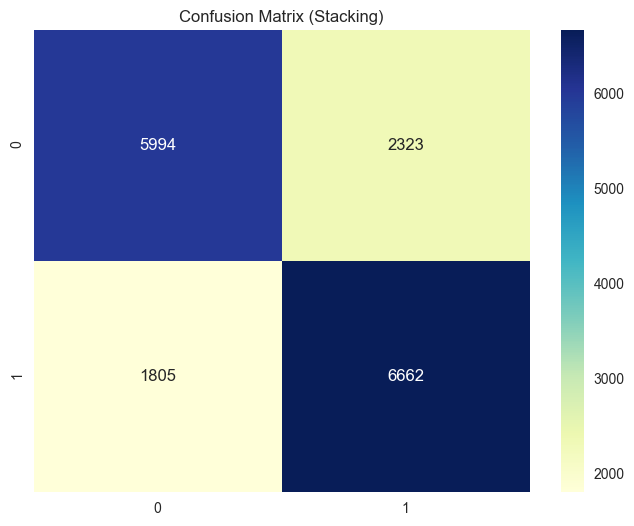

In [44]:
plt.figure(figsize=(8, 6))
ax = sns.heatmap(confusion_stack, cmap = 'YlGnBu',annot = True, fmt='d')
ax.set_title('Confusion Matrix (Stacking)')

## Soft Voting

In [45]:
blend_soft = blend_models(estimator_list = top_5_tuned, optimize = 'AUC',method = 'soft')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7551,0.8263,0.7877,0.7395,0.7628,0.5102,0.5113
1,0.7455,0.8250,0.7740,0.7323,0.7526,0.4911,0.4919
2,0.7430,0.8171,0.7749,0.7284,0.7509,0.4860,0.4870
3,0.7534,0.8270,0.7847,0.7385,0.7609,0.5068,0.5078
4,0.7485,0.8258,0.7762,0.7355,0.7553,0.4970,0.4978
5,0.7404,0.8089,0.7778,0.7236,0.7497,0.4807,0.4821
6,0.7408,0.8234,0.7676,0.7285,0.7475,0.4816,0.4823
7,0.7448,0.8176,0.7812,0.7282,0.7537,0.4897,0.4910
8,0.7444,0.8231,0.7677,0.7336,0.7503,0.4888,0.4893


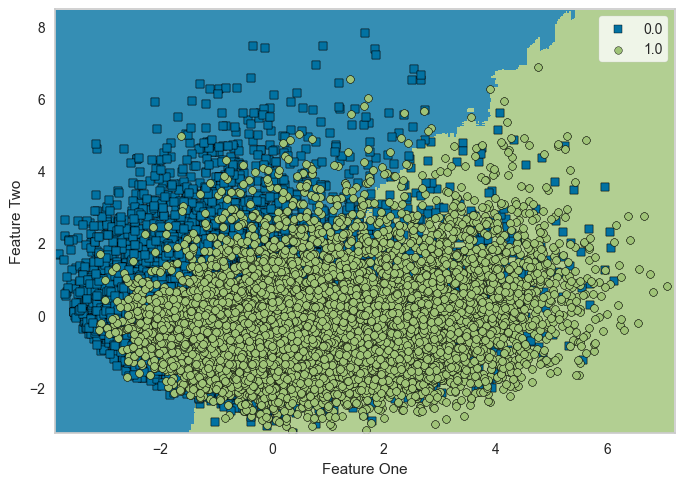

In [46]:
plt.figure(figsize=(8, 8))
plot_model(blend_soft, plot='boundary')

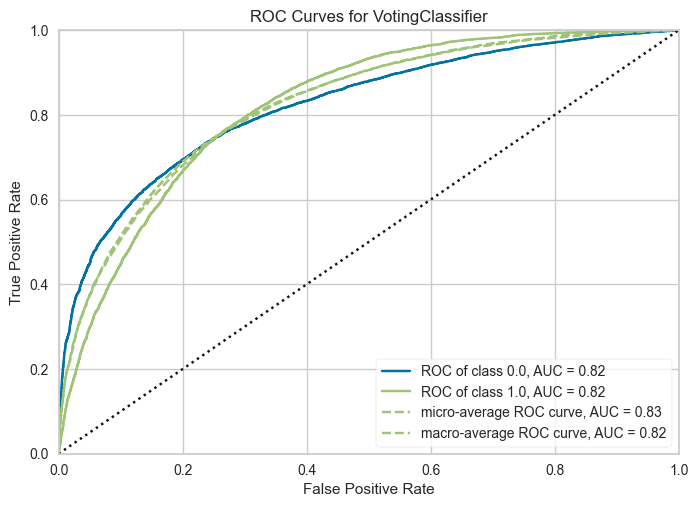

In [56]:
plt.figure(figsize=(8, 8))
plot_model(blend_soft, plot = 'auc')

In [58]:
#prediction
pred = blend_soft.predict(X_test)
pred_proba = blend_soft.predict_proba(X_test)[:,1]
#Accuracy
confusion_blend_soft= get_clf_eval(y_test,pred,pred_proba)

accuracy: 0.7467, precision: 0.7340, recall: 0.7808,    F1: 0.7567, AUC:0.8228


Text(0.5, 1.0, 'Confusion Matrix (blend_soft)')

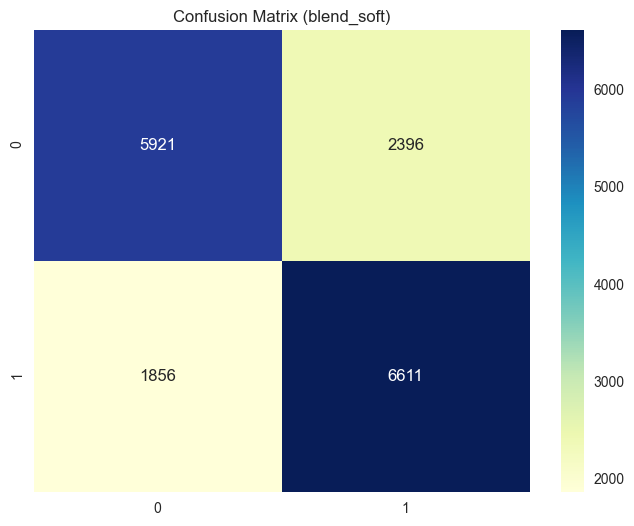

In [59]:

plt.figure(figsize=(8, 6))
ax = sns.heatmap(confusion_blend_soft, cmap='YlGnBu', annot=True, fmt='d')
ax.set_title('Confusion Matrix (blend_soft)')

## Hard Voting

In [61]:
blend_hard = blend_models(estimator_list = top_5_tuned, optimize = 'AUC',method = 'hard')

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,16:53:21
Status,. . . . . . . . . . . . . . . . . .,Compiling Estimators
Estimator,. . . . . . . . . . . . . . . . . .,Voting Classifier


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7538,0.0000,0.7821,0.7402,0.7606,0.5077,0.5085
1,0.7453,0.0000,0.7694,0.7341,0.7513,0.4906,0.4912
2,0.7426,0.0000,0.7715,0.7293,0.7498,0.4851,0.4859
3,0.7536,0.0000,0.7791,0.7413,0.7598,0.5072,0.5079
4,0.7500,0.0000,0.7766,0.7374,0.7565,0.5000,0.5007
5,0.7387,0.0000,0.7731,0.7232,0.7473,0.4773,0.4785
6,0.7380,0.0000,0.7616,0.7272,0.7440,0.4761,0.4766
7,0.7427,0.0000,0.7744,0.7282,0.7506,0.4854,0.4864
8,0.7427,0.0000,0.7626,0.7335,0.7478,0.4854,0.4858


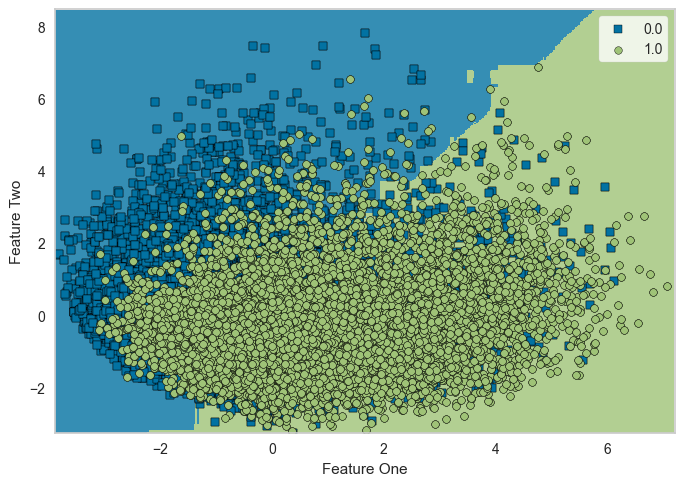

In [62]:
plt.figure(figsize=(8, 8))
plot_model(blend_hard, plot='boundary')

In [63]:
#prediction
pred = blend_hard.predict(X_test)
#Accuracy
confusion_hard = confusion_matrix( y_test, pred)
accuracy = accuracy_score(y_test , pred)
precision = precision_score(y_test , pred)
recall = recall_score(y_test , pred)
f1 = f1_score(y_test,pred) 
print('accuracy: {0:.4f}, precision: {1:.4f}, recall: {2:.4f},\
F1: {3:.4f}'.format(accuracy, precision, recall, f1))

accuracy: 0.7462, precision: 0.7349, recall: 0.7774,F1: 0.7556


Text(0.5, 1.0, 'Confusion Matrix (Hard Blending)')

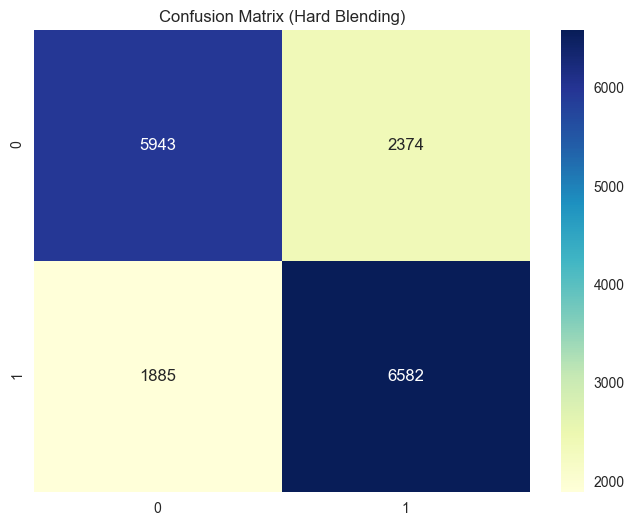

In [64]:
plt.figure(figsize=(8, 6))
ax = sns.heatmap(confusion_hard, cmap = 'YlGnBu',annot = True, fmt='d')
ax.set_title('Confusion Matrix (Hard Blending)')

## 最終校準模型
根據上述的方法嘗試過後，選用Stacking模型，進行最後校準

In [66]:
cali_model = calibrate_model(stack_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7523,0.8288,0.7813,0.7385,0.7593,0.5047,0.5055
1,0.7470,0.8265,0.7698,0.7363,0.7527,0.4940,0.4946
2,0.7421,0.8192,0.7706,0.7291,0.7493,0.4843,0.4850
3,0.7534,0.8278,0.7783,0.7414,0.7594,0.5068,0.5074
4,0.7466,0.8275,0.7753,0.7332,0.7537,0.4932,0.4940
5,0.7382,0.8105,0.7744,0.7221,0.7473,0.4765,0.4777
6,0.7431,0.8260,0.7676,0.7317,0.7492,0.4863,0.4869
7,0.7438,0.8190,0.7786,0.7278,0.7524,0.4876,0.4888
8,0.7474,0.8226,0.7698,0.7369,0.7530,0.4948,0.4953


In [67]:
final_model = finalize_model(cali_model)

In [68]:
final_model

Pipeline(memory=Memory(location=None),
         steps=[('placeholder', None),
                ('actual_estimator',
                 CalibratedClassifierCV(base_estimator=StackingClassifier(cv=5,
                                                                          estimators=[('CatBoost '
                                                                                       'Classifier',
                                                                                       <catboost.core.CatBoostClassifier object at 0x000001A9D4157850>),
                                                                                      ('Gradient '
                                                                                       'Boosting '
                                                                                       'Classifier',
                                                                                       GradientBoostingClassifier(ccp_alpha=0.0,
                                                                                                                  criterion='friedman_mse',
                                                                                                                  init...
                                                                                       LinearDiscriminantAnalysis(covariance_estimator=None,
                                                                                                                  n_components=None,
                                                                                                                  priors=None,
                                                                                                                  shrinkage=None,
                                                                                                                  solver='svd',
                                                                                                                  store_covariance=False,
                                                                                                                  tol=0.0001))],
                                                                          final_estimator=<catboost.core.CatBoostClassifier object at 0x000001A9D4157B50>,
                                                                          n_jobs=-1,
                                                                          passthrough=True,
                                                                          stack_method='auto',
                                                                          verbose=0),
                                        cv=5, ensemble=True, estimator=None,
                                        method='sigmoid', n_jobs=None))],
         verbose=False)

In [70]:
# plt.figure(figsize=(8, 8))
# plot_model(final_model, plot='threshold')

KeyboardInterrupt: 

<Figure size 800x550 with 0 Axes>

In [72]:
X_test.columns

Index(['HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker', 'Stroke',
       'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth',
       'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education',
       'Income'],
      dtype='object')

In [73]:
value = [1,0.0,1,30.0,1.0,0.0,1.0,1,1,1,0,1,0.0,4.0,3.0,5.0,0.0,1,9,6.0,9.0]
# 建立一個新的dataframe
new_df = pd.DataFrame([value], columns=X_test.columns)
new_df

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,1,0.0,1,30.0,1.0,0.0,1.0,1,1,1,...,1,0.0,4.0,3.0,5.0,0.0,1,9,6.0,9.0


In [76]:
pred = final_model.predict(new_df)
pred_proba = final_model.predict_proba(new_df)[:,1]
print('Prediction : ', pred)
print('Probability : ', pred_proba) 

Prediction :  [1.]
Probability :  [0.77509132]


In [81]:
save_model(final_model, 'Final_Model')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('placeholder', None),
                 ('actual_estimator',
                  CalibratedClassifierCV(base_estimator=StackingClassifier(cv=5,
                                                                           estimators=[('CatBoost '
                                                                                        'Classifier',
                                                                                        <catboost.core.CatBoostClassifier object at 0x000001A9D4157850>),
                                                                                       ('Gradient '
                                                                                        'Boosting '
                                                                                        'Classifier',
                                                                                        GradientBoostingClassifier(ccp_alpha=0.0,
             

In [78]:
# load the model from disk
loaded_model = load_model('Final_Model')

Transformation Pipeline and Model Successfully Loaded


In [79]:
# prediction
pred = loaded_model.predict(X_test)
pred_proba = loaded_model.predict_proba(X_test)[:,1]
# Accuracy
confusion_final = get_clf_eval(y_test,pred,pred_proba)

accuracy: 0.7510, precision: 0.7397, recall: 0.7814,    F1: 0.7600, AUC:0.8306
